In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [9]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [3]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 350.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.3


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3


In [4]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


# Multi Agent Support

In [5]:
ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [6]:
@time ibr(ip, 3, "ego", velo_agent_1, velo_agent_2)

  0.356096 seconds (501.35 k allocations: 40.060 MiB, 85.55% compilation time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


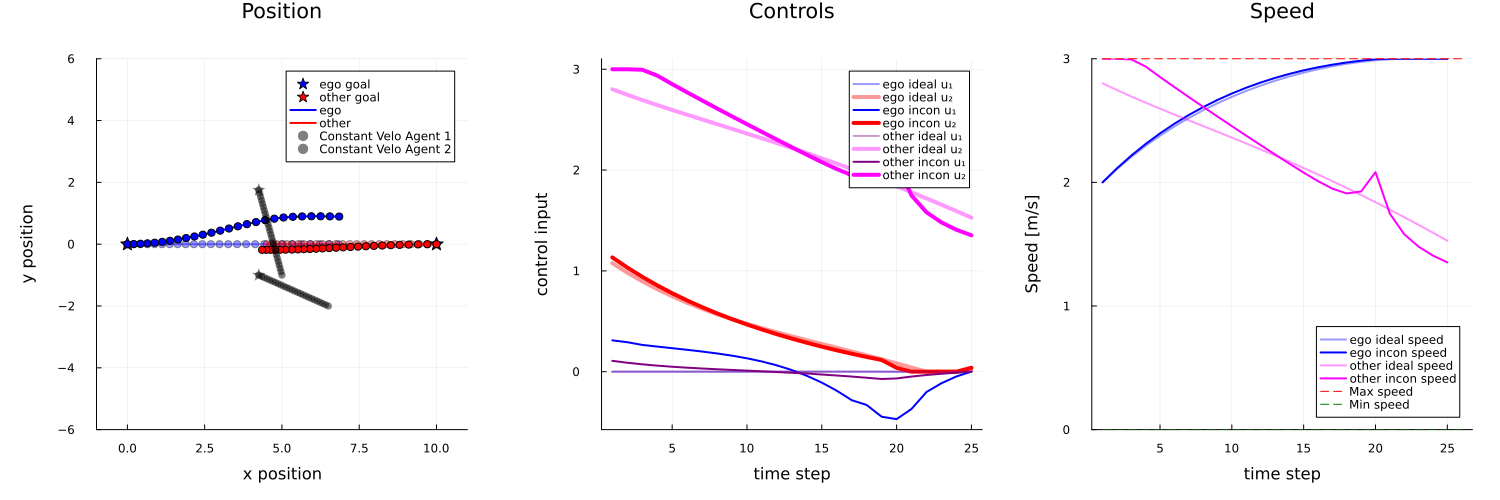

In [7]:
plot_solve_solution(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

┌ Info: Saved animation to /tmp/jl_9oVWJOFCJc.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_9oVWJOFCJc.gif")
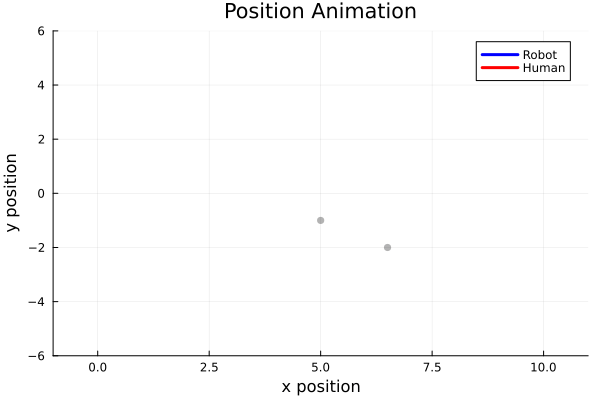

In [8]:
animation(ip, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Simulation Implementation

In [10]:
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(robot_ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(robot_ip.other_planner.incon, velo_agent_1, velo_agent_2)

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(human_ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(human_ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [11]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [99.00000006741392, 93.43346281010106, 88.0348110788002, 82.77749750095941, 77.63804623988577, 72.59551941508585, 67.6311203314979, 62.72789780128181, 57.87051843852322, 53.04508034189561  …  19.22

In [12]:
robot_xs, robot_us, human_xs, human_us = simulate(robot_ip, human_ip, 50, velo_agent_1, velo_agent_2)

([0.0 0.0 0.0 2.0; 0.20265785109298048 -0.0003933961548902681 -0.0038654612377417193 2.053167181648348; … ; 10.049721071878967 -0.0024542646795421685 -0.10996008774197667 0.7377336270311664; 10.119833510946508 -0.006721751573369008 -0.00996118110548816 0.6676952403848324], [-0.03865461237741719 0.5316718164834812; 0.008838775311795664 1.3247071988905237; … ; -0.09753152003133567 -0.803422953369285; 0.999989066364885 -0.7003838664633402], [10.0 0.0 3.141592653589793; 9.700005416281526 0.0004373031379365784 3.1386772487662764; … ; 0.842876806957563 -0.1359758303051924 2.984486807866347; 0.7965716601254745 -0.12864057128712122 2.984237108227728], [-0.029154048235166773 2.9999500869048425; 0.8889709665131651 2.9991326203149855; … ; -0.0026356171033919953 0.49606423184529463; -0.0024969963861942164 0.46882540972130105])

In [13]:
sim_data = SimData(sim_params, robot_xs, robot_us, human_xs, human_us)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 350.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.3
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-101.26796891245557, -102.7625795944974, -104.1416847537795, -105.4286652060308, -106.6434932089013, -107.80126172743313, -108.91144761958543, -109.97800251359278, -111.00007703085386, -11

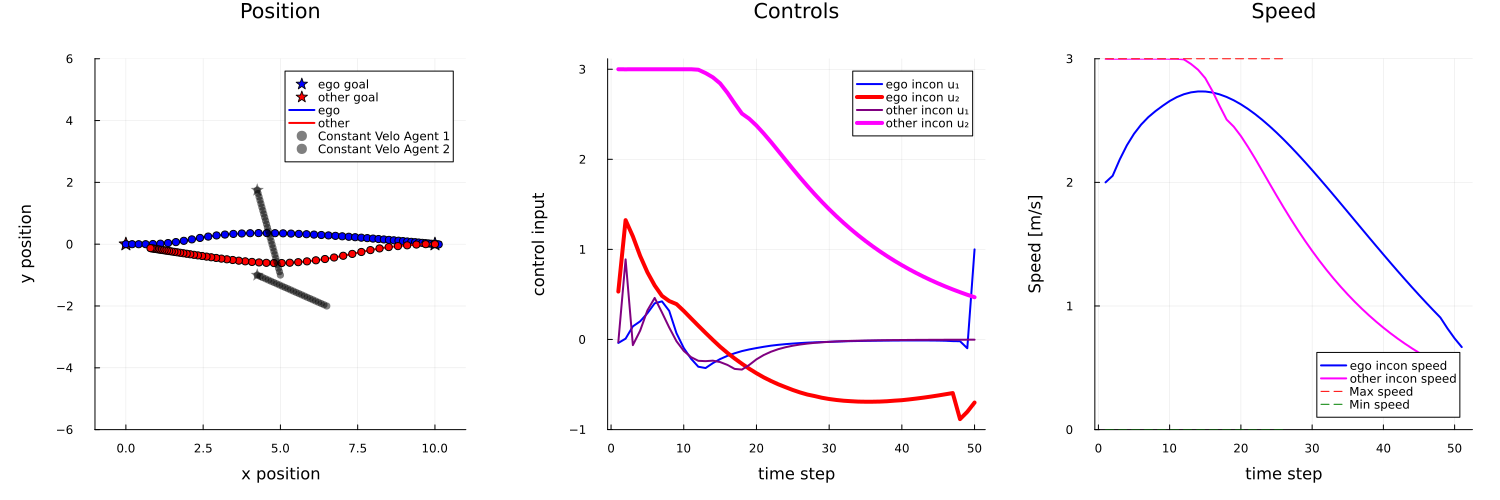

In [14]:
plot_solve_solution(sim_data, velo_agent_1, velo_agent_2)

In [15]:
# bad plotting code but used for animation demonstration

function animation(ego_path::Matrix{Float64}, other_path::Matrix{Float64}, constant_velo_agents::ConstantVeloAgent...; pos_xlims=[-1, 8], pos_ylims=[-3, 3], save_name="none")
    a = Animation()

    linewidth = 3
    alpha_ideal = 0.2
    ego_color = :blue
    other_color = :red

    ego_xs = ego_path
    other_xs = other_path

    N_velo_agents = length(constant_velo_agents)
    constant_velo_agents_pos = Vector{Matrix{Float64}}(undef, N_velo_agents)
    
    for i in 1:N_velo_agents
        constant_velo_agents_pos[i] = vector_of_vectors_to_matrix(get_constant_velocity_agent_positions(ip.ego_planner.incon, constant_velo_agents[i]))
    end

    constant_velo_length = length(constant_velo_agents_pos[1][:, 1])

    plt = plot(xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", arrow=true, aspect_ration=:equal)


    for i in 1:length(ego_xs[:, 1]) - 1
        # plot!(plt, ego_ideal_xs[1:i,1], ego_ideal_xs[1:i,2], color=:purple, linewidth=linewidth, lab="", alpha=alpha_ideal)
        plt = plot(ego_xs[1:i,1], ego_xs[1:i,2], color=ego_color, linewidth=linewidth, lab="", xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation")
        # plot!(plt, other_ideal_xs[1:i,1], other_ideal_xs[1:i,2], color=:magenta, linewidth=linewidth, lab="", alpha=alpha_ideal)
        plot!(plt, other_xs[1:i,1], other_xs[1:i,2], color=other_color, linewidth=linewidth, lab="")

        if i <= constant_velo_length
            for j in 1:N_velo_agents
                scatter!(plt, constant_velo_agents_pos[j][i:i, 1], constant_velo_agents_pos[j][i:i, 2], label="", color=:black, alpha=0.3)
            end
        end

        frame(a, plt)
    end

    if save_name != "none"
        gif(a, "../animations/$save_name.gif", fps = 15) 
    end 

    return gif(a, fps=60)
end

animation (generic function with 4 methods)

┌ Info: Saved animation to /tmp/jl_5InApMjG9i.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_5InApMjG9i.gif")
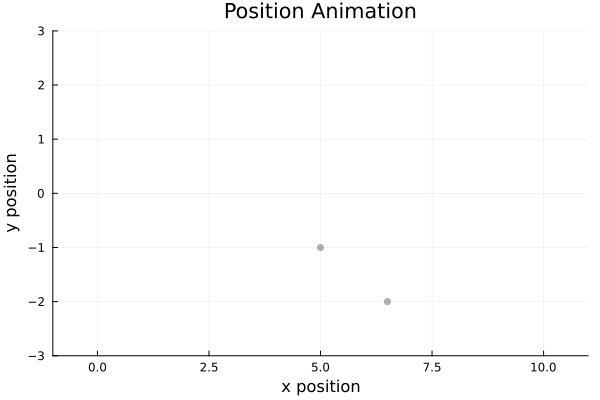

In [16]:
animation(robot_xs, human_xs, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11])